# Evaluate a trained model

## Setup

```
jupyter nbextension enable --py widgetsnbextension
```

In [84]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import pickle
import shutil
import sys
import random

import azureml.core
from azureml.core import Workspace
from azureml.core.dataset import Dataset
import glob2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
from tqdm.notebook import tqdm

print("Azure ML SDK Version: ", azureml.core.VERSION)

sys.path.append(str(Path(os.getcwd()).parent / 'evaluation/QA/eval_depthmap_models/src'))

from eval_utils import calculate_performance, CODE_TO_SCANTYPE, CONFIG, REPO_DIR, preprocess_targets, preprocess_depthmap, tf_load_pickle, preprocess, extract_qrcode, extract_scantype, avgerror
from evaluate import predict_uncertainty, get_prediction_uncertainty
from utils import draw_uncertainty_goodbad_plot

Azure ML SDK Version:  1.18.0


### Select the  model to be evaluated from workspace

In [2]:
workspace = Workspace.from_config()

selected_experiments = ["q3-depthmap-plaincnn-height-95k"]

# RUN_ID = 'q3-depthmap-plaincnn-height-95k_1597988908_42c4ef33'  # Run3
RUN_ID = 'q3-depthmap-plaincnn-height-95k_1600451633_cb44f6db'  # Run17

OUTPUT_DIR = 'data/logs/q3-depthmap-plaincnn-height-95k/run_03/'

### Download the models on your local system for evaluation

### Load the models

In [3]:
REPO_DIR

PosixPath('/Users/markus/Development/cgm/cgm-ml')

In [4]:
MODEL_PATH = str(REPO_DIR / f"data/{RUN_ID}/best_model.h5")

model = load_model(MODEL_PATH)
# summarize model.
# model.summary()

### Show a sample from the testset

In [ ]:
# paths = '../testdepthmap1/1585551618-hlby208u8z/pc_1585551618-hlby208u8z_1593156356859_100_000.p'
paths = REPO_DIR / "data/anon-depthmap-testset/scans/1585013728-90norqfryy/100/pc_1585013728-90norqfryy_1591850340061_100_000.p"

depthmap, targets = pickle.load(open(paths, "rb"))
depthmap = preprocess_depthmap(depthmap)
depthmap = depthmap / depthmap.max()
print("depthmap_max:", depthmap.max())
depthmap = tf.image.resize(depthmap, (CONFIG.IMAGE_TARGET_HEIGHT, CONFIG.IMAGE_TARGET_WIDTH))
targets = preprocess_targets(targets, CONFIG.TARGET_INDEXES)
depthmap.set_shape((CONFIG.IMAGE_TARGET_HEIGHT, CONFIG.IMAGE_TARGET_WIDTH, 1))
# targets.set_shape((len(targets_indices,)))
plt.imshow(np.squeeze(depthmap), cmap='gray');

## Dataset

To use the dataset, you can:
- mount the dataset
- use datastore (blob storage)
- download the dataset

Choose your preferred way and make sure to adjust the absolute path

In [5]:
# DATASET_PATH = str(REPO_DIR / "data/anon-depthmap-testset/scans/*/*/")
DATASET_PATH = str(REPO_DIR / "data/anon-realtime-testdata/scans/*/*/")

### Perform the prediction

In [62]:
prediction_folder = glob2.glob(DATASET_PATH); prediction_folder[:3]

['/Users/markus/Development/cgm/cgm-ml/data/anon-realtime-testdata/scans/1585013299-lb13d119ep/102',
 '/Users/markus/Development/cgm/cgm-ml/data/anon-realtime-testdata/scans/1585013299-lb13d119ep/100',
 '/Users/markus/Development/cgm/cgm-ml/data/anon-realtime-testdata/scans/1585013299-lb13d119ep/101']

In [63]:
len(prediction_folder)

551

In [64]:
prediction_folder = prediction_folder[:500]  # reduce size for DEBUG speed

predictions = []
uncertainties = []
file_names = []
targets_list = []
for qrcode in tqdm(prediction_folder):
    depthfiles = []
    depthmaps = glob2.glob(qrcode + '/*.p')
    files = depthmaps[0]
    depths, targets = preprocess(files)

    sample = np.expand_dims(depths, axis=0)
    
    inference = model.predict(sample)
    uncertainties.append(predict_uncertainty(sample, model))
    file_names.append(files)
    predictions.append(np.squeeze(inference))
    targets_list.append(targets)

Key 'delete' not found in GOODBAD_DICT
Key 'delete' not found in GOODBAD_DICT
Key 'delete' not found in GOODBAD_DICT
Key 'delete' not found in GOODBAD_DICT
Key 'delete' not found in GOODBAD_DICT
Key 'delete' not found in GOODBAD_DICT



EOFError: Ran out of input

In [31]:
IMAGE_TARGET_HEIGHT=240
IMAGE_TARGET_WIDTH=180
TARGET_INDEXES=[0, 5]  # 0 is height, 5 is good/bad
def py_load_pickle(path, max_value=7.5):
    path_ = path if isinstance(path, str) else path.numpy()
    depthmap, targets = pickle.load(open(path_, "rb"))
    depthmap = preprocess_depthmap(depthmap)
    depthmap = depthmap / max_value
    depthmap = tf.image.resize(depthmap, (IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH))
    targets = preprocess_targets(targets, TARGET_INDEXES)
    return depthmap, targets

def path_to_ndarray(pickle_file_path):
    depthmap, _targets = py_load_pickle(pickle_file_path)
    depthmap = tf.reshape(depthmap, (IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH))
    return depthmap.numpy(), _targets

In [32]:
predictions[0]

array(77.34606, dtype=float32)

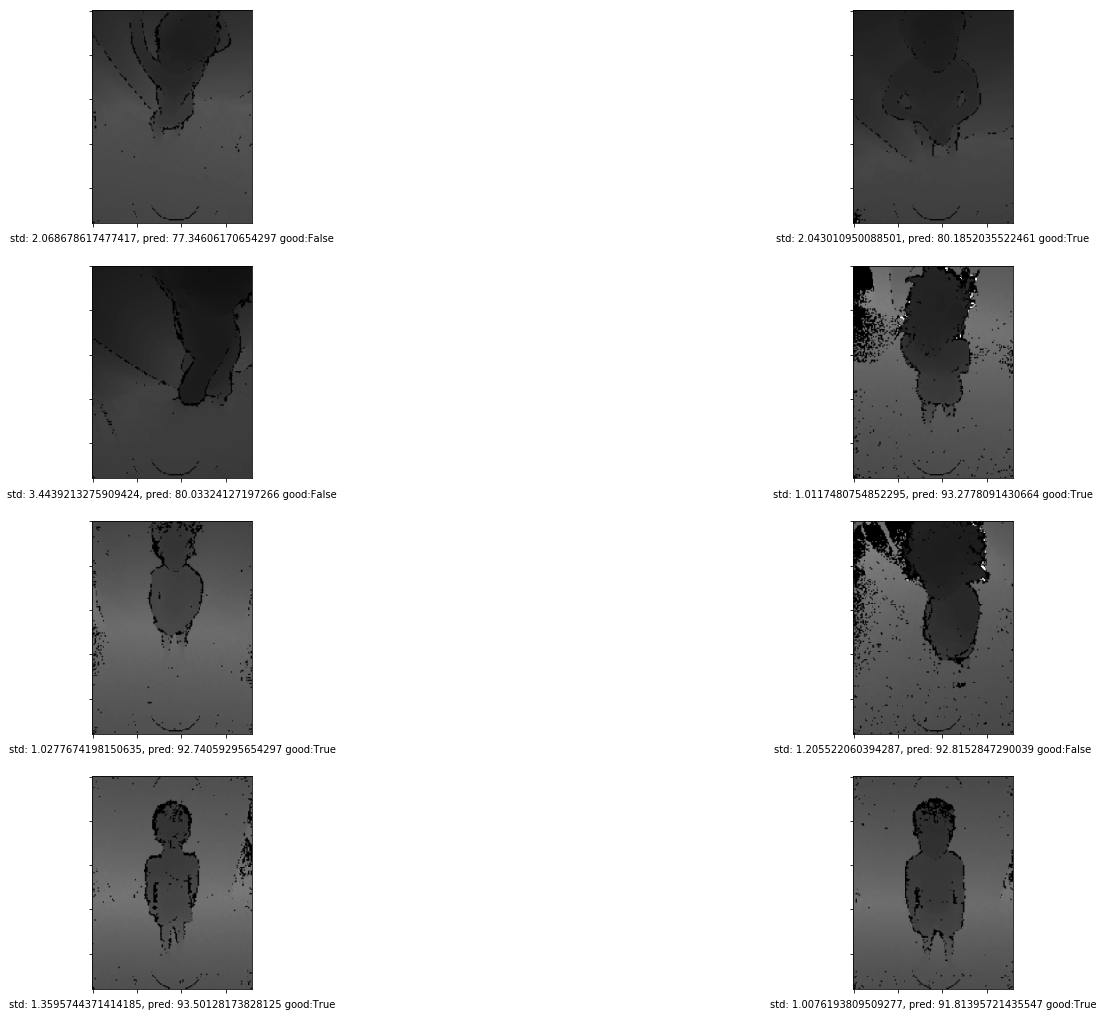

In [33]:
num_height, num_width = 4, 2
fig, axarr = plt.subplots(num_height, num_width, figsize=(25, 18))

for x in range(num_height):
    for y in range(num_width):
        i = x * num_width + y
        fpath = file_names[i]
        arr, targets = path_to_ndarray(fpath)
        axarr[x,y].imshow(arr, cmap='gray', vmin=0, vmax=0.5);  # vmax=1
        axarr[x,y].set_xticklabels([])
        axarr[x,y].set_yticklabels([])
        
        label = f"std: {uncertainties[i]}, pred: {predictions[i]} good:{bool(targets[1])}"
        axarr[x,y].set_xlabel(label)
#         axarr[x,y].set_xlabel(fname[-12:]+ f" is {targets[0]:.2f}cm")
plt.show()

In [71]:
assert len(predictions) == len(uncertainties) == len(file_names) == len(targets_list)
print(len(predictions))

df = pd.DataFrame(
    {'predictions': predictions,
     'uncertainties': [u.numpy() for u in uncertainties],
     'file_names': file_names,
     'targets_list': targets_list
    })
# Preproc
df['height_measured'] = df.targets_list.apply(lambda x: x[0])
df['goodbad'] = df.targets_list.apply(lambda x: x[1])
df.drop(labels="targets_list", axis=1, inplace=True)
df['error'] = abs(df['height_measured'] - df['predictions'])

445


In [72]:
df.head()

,predictions,uncertainties,file_names,height_measured,goodbad,error
0,77.34606,1.563632,/Users/markus/Development/cgm/cgm-ml/data/anon...,82.300003,0.0,4.95394
1,80.1852,2.694995,/Users/markus/Development/cgm/cgm-ml/data/anon...,82.300003,1.0,2.1148
2,80.03324,3.762125,/Users/markus/Development/cgm/cgm-ml/data/anon...,82.300003,0.0,2.26676
3,93.27781,0.982655,/Users/markus/Development/cgm/cgm-ml/data/anon...,91.500000,1.0,1.77781
4,92.74059,1.095509,/Users/markus/Development/cgm/cgm-ml/data/anon...,91.500000,1.0,1.24059


In [76]:
print(df_good.uncertainties.mean())
print(df_bad.uncertainties.mean())
# This looks good, let's plot the distributions

1.3434886085480797
2.20683114150519


In [95]:
SAVE_PATH='./outputs/height'
OUTPUT_CSV_PATH = REPO_DIR / 'data' / SAVE_PATH
os.makedirs(OUTPUT_CSV_PATH, exist_ok=True)
image_path = f"{str(OUTPUT_CSV_PATH)}/uncertainty_distribution_{RUN_ID}.png"
draw_uncertainty_goodbad_plot(df, image_path)

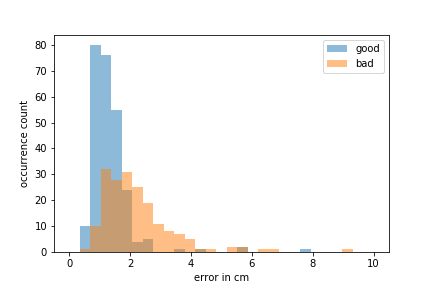

In [104]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename=image_path, width=500, height=500)

# Old stuff

In [38]:
# Put predictions into dataframe
df = pd.DataFrame([])
for i in tqdm(range(len(predictions))):
    label = np.array(predictions[i][3]).flatten()
    data = pd.DataFrame({
        'qrcode':predictions[i][0],
        'artifacts': predictions[i][1],
        'predicted':predictions[i][2],
        'GT':label,
    })
    df = df.append(data)
df.head()

,qrcode,artifacts,predicted,GT
0,/Users/markus/Development/cgm/cgm-ml/data/anon...,/Users/markus/Development/cgm/cgm-ml/data/anon...,79.586510,82.300003
1,/Users/markus/Development/cgm/cgm-ml/data/anon...,/Users/markus/Development/cgm/cgm-ml/data/anon...,82.762001,82.300003
2,/Users/markus/Development/cgm/cgm-ml/data/anon...,/Users/markus/Development/cgm/cgm-ml/data/anon...,82.641182,82.300003
3,/Users/markus/Development/cgm/cgm-ml/data/anon...,/Users/markus/Development/cgm/cgm-ml/data/anon...,82.757225,82.300003
4,/Users/markus/Development/cgm/cgm-ml/data/anon...,/Users/markus/Development/cgm/cgm-ml/data/anon...,81.590736,82.300003


In [ ]:
df['qrcode'] = df.apply(extract_qrcode, axis=1)
df.head()

In [ ]:
df['artifacts'].iloc[1]  # sample of how the artifacts path looks like for me, modify it accordingly to suit your path dependency

In [ ]:
len(df['qrcode'].unique()) ## total number of scans

In [ ]:
df['scantype'] = df.apply(extract_scantype, axis=1)
df['scantype'].value_counts()

### Group the results of artifacts by qrcode and scantype by taking mean across the same scantype

In [ ]:
MAE = df.groupby(['qrcode', 'scantype']).mean()
MAE

## Error between predicted and ground truth

In [ ]:
MAE['error'] = MAE.apply(avgerror, axis=1)
MAE

In [ ]:
# unique name for the index values
model_name = 'q3-depthmap-plaincnn-height-100-95k'
run_no ='_front_run_03'
complete_name = model_name + run_no; complete_name

## Calculate accuracies across the scantypes

In [ ]:
dfs = []
for code in CODE_TO_SCANTYPE.keys():
    df = calculate_performance(code, MAE)
    full_model_name = complete_name + CODE_TO_SCANTYPE[code]
    df.rename(index={0:full_model_name}, inplace=True)
    display(HTML(df.to_html()))
    dfs.append(df)

## Combine the results for all accuracies

In [ ]:
result = pd.concat(dfs)
result.index.name = 'Model_Scantype'
result = result.round(2)
result

In [ ]:
# Save the model results in csv file
CSV_OUT_PATH = REPO_DIR / 'data' / 'eval' / RUN_ID / 'result.csv'
Path(CSV_OUT_PATH.parent).mkdir(parents=True, exist_ok=True)
result.to_csv(CSV_OUT_PATH, index=True)